<a href="https://colab.research.google.com/github/EagleZRock/LEGO-Sorter/blob/main/sorter_training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/EagleZRock/LEGO-Sorter.git
!mkdir ./data
!ls

fatal: destination path 'LEGO-Sorter' already exists and is not an empty directory.
mkdir: cannot create directory ‘./data’: File exists
data  LEGO-Sorter  sample_data


In [4]:
# Import Tensorflow
import tensorflow as tf

# Import tools
import os
import matplotlib.pyplot as plt
import json
import numpy as np
from scipy import stats

# Viewing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import Keras
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Dropout, Lambda, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

# Tensorboard
from tensorboard import program
import webbrowser
import time

In [5]:
################################
# Training Parameters
#################################

continue_training       = False
initial_epoch           = 0
clear_logs              = True

input_shape             = (64, 64, 3) # This is the shape of the image width, length, colors
image_size              = (input_shape[0], input_shape[1]) # DOH! image_size is (height, width)
train_test_ratio        = 0.3
zoom_range              = 0.2
shear_range             = 0.1

# Hyperparameters
batch_size              = 32
epochs                  = 100
steps_per_epoch         = 100
validation_steps        = 100
optimizer               = 'adam'
learning_rate           = 0.001
val_save_step_num       = 1
dropout                 = 0.0

path_to_graphs          = './data/output/logs/'
model_save_dir          = './data/output/'
train_dir               = './LEGO-Sorter/data/outputtrain/'
val_dir                 = './LEGO-Sorter/data/outputtest/'

In [6]:
#################################
# Helper functions
#################################

if clear_logs:
  !rm -rf data/output/logs/*

def make_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)


def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history['loss'], label='Train loss')
    ax[0].plot(history.epoch, history.history['val_loss'], label='Validation loss')
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history['acc'], label='Train acc')
    ax[1].plot(history.epoch, history.history['val_acc'], label='Validation acc')
    ax[0].legend()
    ax[1].legend()

#################################
# Create needed dirs
#################################
make_dir(model_save_dir)

In [7]:
#################################
# Data generators
#################################

augs_gen = ImageDataGenerator (
    shear_range = shear_range,
    brightness_range = [0.6, 1.2],
    rotation_range = 70,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = zoom_range,
    horizontal_flip = True,
    validation_split = train_test_ratio,
    fill_mode = 'nearest'
)

train_gen = augs_gen.flow_from_directory (
    train_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'sparse',
    shuffle = True,
)

test_gen = augs_gen.flow_from_directory (
    val_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'sparse',
    shuffle = False,
)

Found 42000 images belonging to 15 classes.
Found 17985 images belonging to 15 classes.


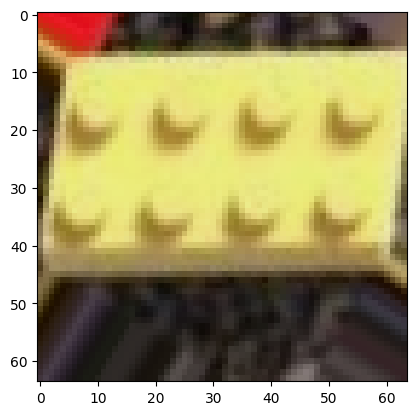

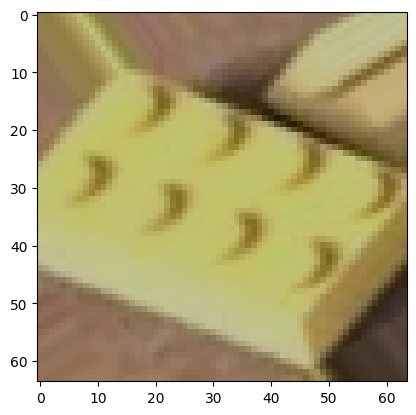

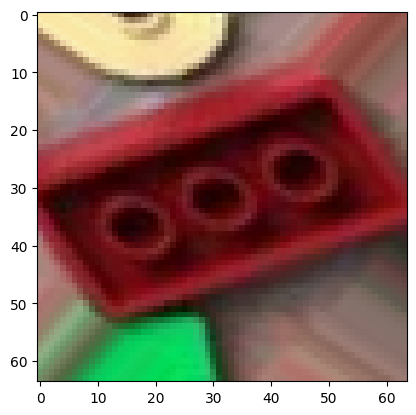

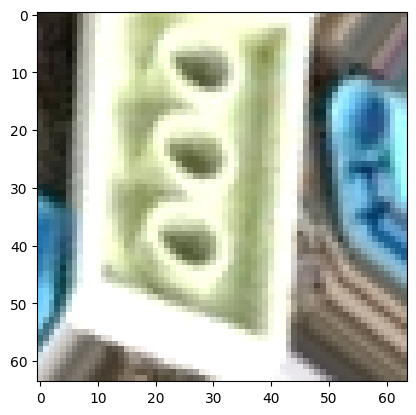

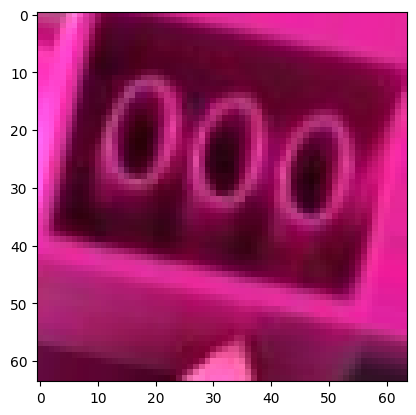

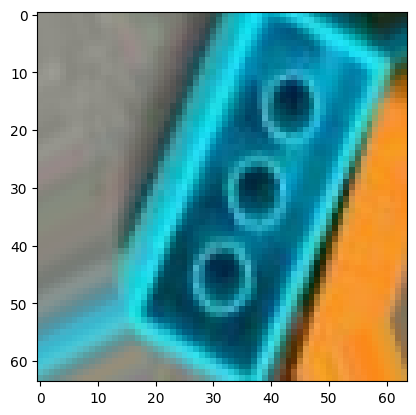

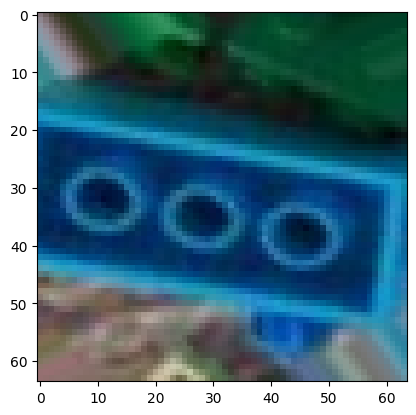

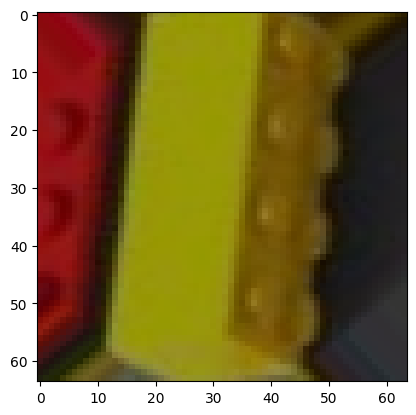

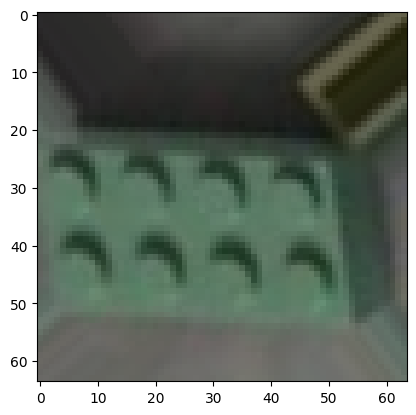

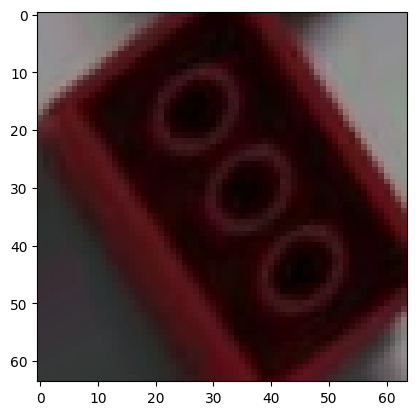

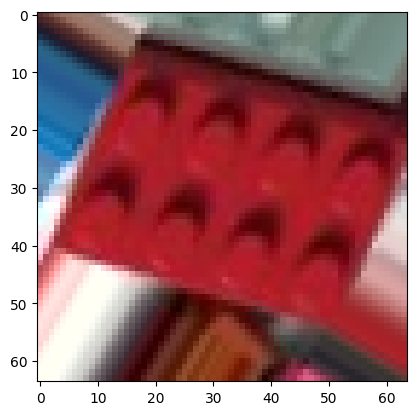

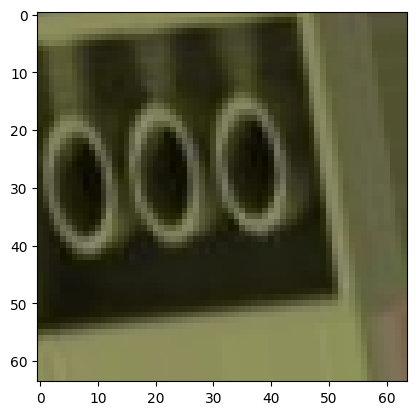

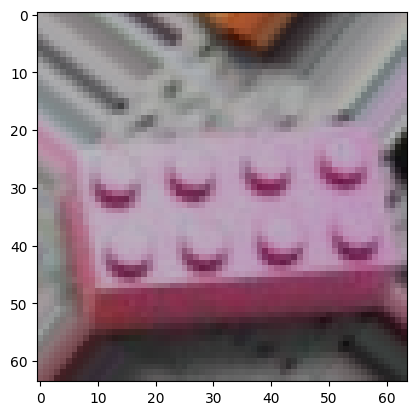

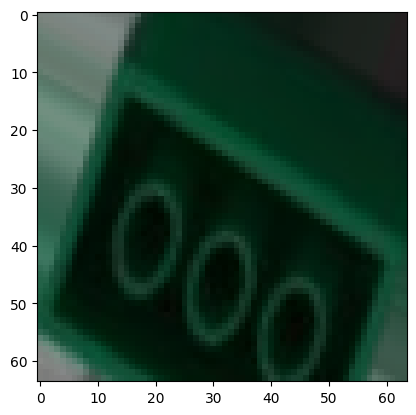

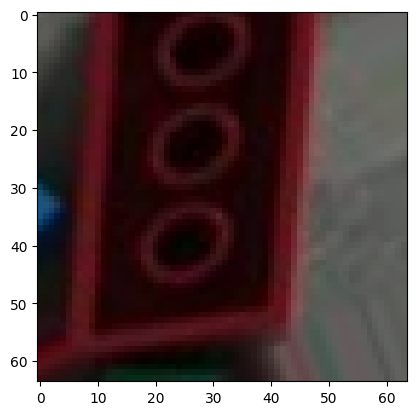

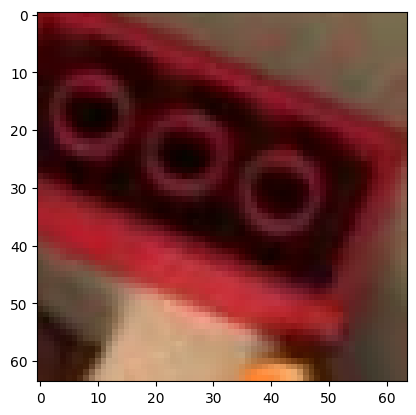

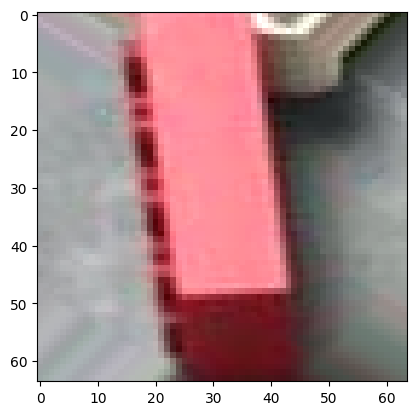

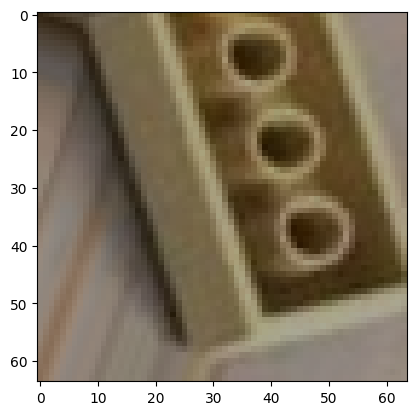

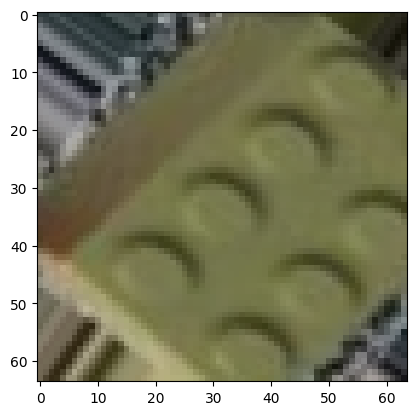

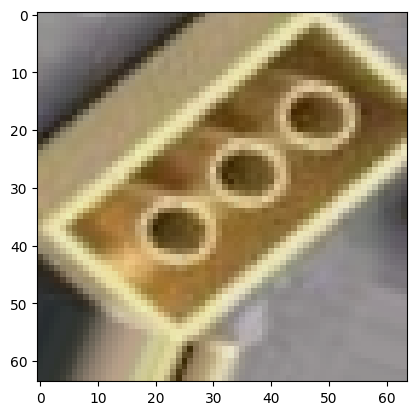

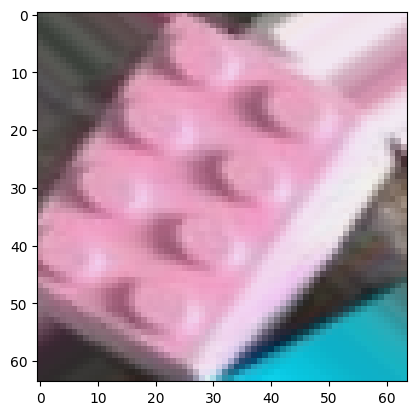

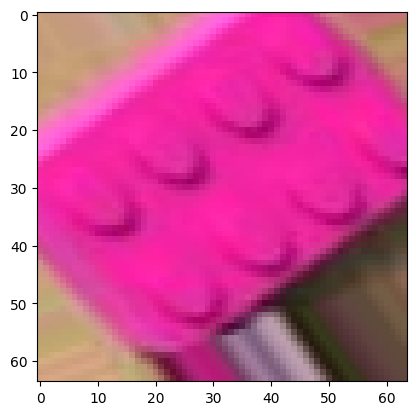

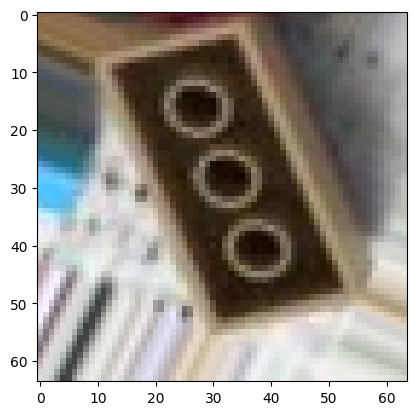

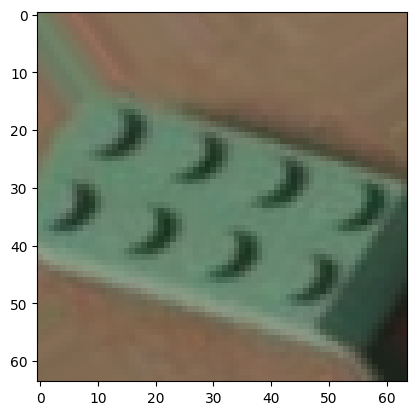

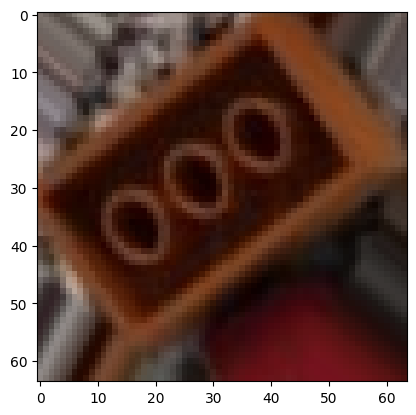

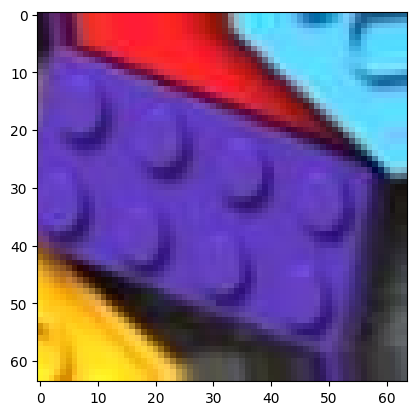

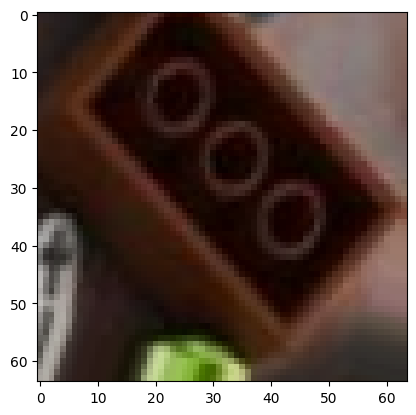

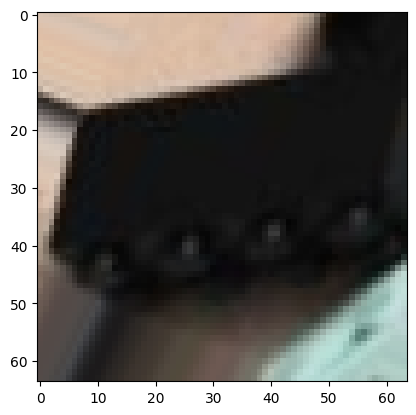

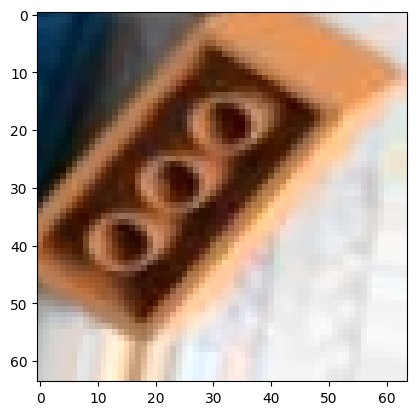

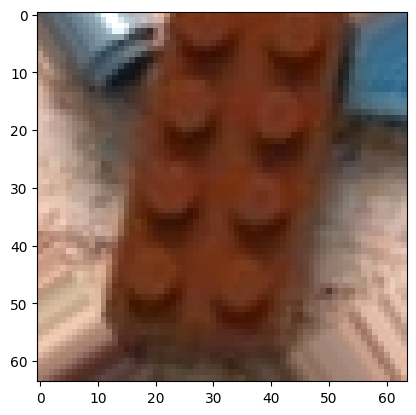

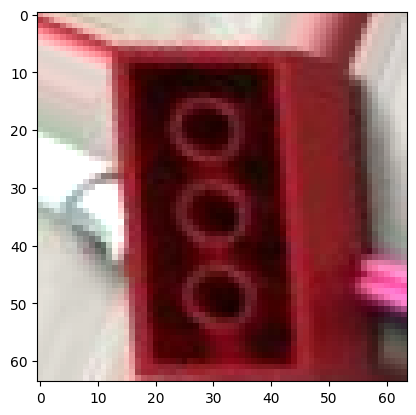

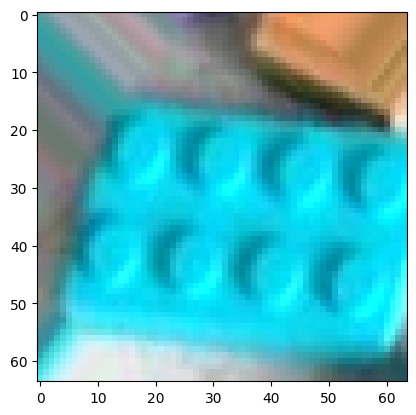

In [8]:
#################################
# Check Generator Output
#################################
x_batch, y_batch = next(test_gen)
for i in range(x_batch.shape[0]):
    plt.imshow(x_batch[i].astype('uint8'))
    plt.show()

In [9]:
#################################
# Save Class IDs
#################################

classes_json = train_gen.class_indices
num_classes = len(train_gen.class_indices)

with open(model_save_dir + 'classes.json', 'w') as fp:
    json.dump(classes_json, fp, indent = 4)

In [11]:
#################################
# Model Building
#################################

def test_model(opt, input_shape, dropout = 0.0):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), input_shape = input_shape))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(32, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(num_classes, activation = 'softmax'))
    return model

In [12]:
#################################
# Create model
#################################

def get_optimizer(optimizer, learning_rate = 0.001):
    if optimizer == 'adam':
        return tf.keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimizer == 'sgd':
        return tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.99)
    elif optimizer == 'adadelta':
        return tf.keras.optimizers.Adadelta(learning_rate = learning_rate, rho=0.95)

selected_optimizer = get_optimizer(optimizer, learning_rate)

model = test_model(selected_optimizer, input_shape)
model.summary()

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = selected_optimizer,
    metrics = ['accuracy']
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 activation (Activation)     (None, 62, 62, 16)        0         
                                                                 
 dropout (Dropout)           (None, 62, 62, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 29, 29, 32)        0         
                                                        

In [13]:

#################################
# Keras Callbacks
#################################
best_model_weights = model_save_dir + 'model.h5'

#Callback to save model weights at every epoch
#Used to help find best model weights
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    mode = 'min',
    save_weights_only = False,
    save_freq = val_save_step_num
)

#Stops training when metric has stopped improving
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)

#Visual representation of tensflow model and data

tensorboard = TensorBoard(
    log_dir = model_save_dir + '/logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)

#Logs data into a csv file
csvlogger = CSVLogger(
    filename = model_save_dir + 'training.csv',
    separator = ',',
    append = False
)

#Reduces the learning rate when the metrics have stopped improving
reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1,
    mode='auto',
    cooldown=1
)

callbacks = [checkpoint, csvlogger, tensorboard]

In [25]:
#################################
# Execute Training
#################################

if continue_training:
    model.load_weights(best_model_weights)
    model_score = model.evaluate_generator(test_gen,)

    print('Model Test Loss:', model_score[0])
    print('Model Test Accuracy:', model_score[1])


history = model.fit(
    train_gen,
    steps_per_epoch  = steps_per_epoch,
    validation_data  = test_gen,
    batch_size = batch_size,
    validation_steps = validation_steps,
    epochs = epochs,
    verbose = 1,
    callbacks = callbacks
)


Epoch 1/100


  1/100 [..............................] - ETA: 11s - loss: 2.7933 - accuracy: 0.0312

  2/100 [..............................] - ETA: 6s - loss: 2.7345 - accuracy: 0.0312 

  3/100 [..............................] - ETA: 7s - loss: 2.7191 - accuracy: 0.0521

  4/100 [>.............................] - ETA: 6s - loss: 2.6792 - accuracy: 0.0703

  5/100 [>.............................] - ETA: 6s - loss: 2.6726 - accuracy: 0.0938

  6/100 [>.............................] - ETA: 6s - loss: 2.6553 - accuracy: 0.0990

  7/100 [=>............................] - ETA: 6s - loss: 2.6455 - accuracy: 0.0938

  8/100 [=>............................] - ETA: 6s - loss: 2.6347 - accuracy: 0.0938

  9/100 [=>............................] - ETA: 6s - loss: 2.6342 - accuracy: 0.0868

 10/100 [==>...........................] - ETA: 6s - loss: 2.6316 - accuracy: 0.0812

 11/100 [==>...........................] - ETA: 6s - loss: 2.6345 - accuracy: 0.0767

 12/100 [==>...........................] - ETA: 6s - loss: 2.6267 - accuracy: 0.0755

 13/100 [==>...........................] - ETA: 6s - loss: 2.6274 - accuracy: 0.0697

 14/100 [===>..........................] - ETA: 6s - loss: 2.6188 - accuracy: 0.0670

 15/100 [===>..........................] - ETA: 6s - loss: 2.6170 - accuracy: 0.0625

 16/100 [===>..........................] - ETA: 5s - loss: 2.6029 - accuracy: 0.0605

 17/100 [====>.........................] - ETA: 5s - loss: 2.5996 - accuracy: 0.0570

 18/100 [====>.........................] - ETA: 5s - loss: 2.5983 - accuracy: 0.0538

 19/100 [====>.........................] - ETA: 5s - loss: 2.5943 - accuracy: 0.0510

 20/100 [=====>........................] - ETA: 5s - loss: 2.5959 - accuracy: 0.0547

 21/100 [=====>........................] - ETA: 5s - loss: 2.5959 - accuracy: 0.0595

 22/100 [=====>........................] - ETA: 5s - loss: 2.5966 - accuracy: 0.0611

 23/100 [=====>........................] - ETA: 5s - loss: 2.6006 - accuracy: 0.0611

 24/100 [======>.......................] - ETA: 5s - loss: 2.5988 - accuracy: 0.0612

 25/100 [======>.......................] - ETA: 5s - loss: 2.6011 - accuracy: 0.0587

 26/100 [======>.......................] - ETA: 5s - loss: 2.5881 - accuracy: 0.0565

 27/100 [=======>......................] - ETA: 5s - loss: 2.5863 - accuracy: 0.0556

 28/100 [=======>......................] - ETA: 5s - loss: 2.5825 - accuracy: 0.0569

 29/100 [=======>......................] - ETA: 5s - loss: 2.5765 - accuracy: 0.0657

 30/100 [========>.....................] - ETA: 4s - loss: 2.5833 - accuracy: 0.0688

 31/100 [========>.....................] - ETA: 4s - loss: 2.5852 - accuracy: 0.0696

 32/100 [========>.....................] - ETA: 4s - loss: 2.5843 - accuracy: 0.0674

 33/100 [========>.....................] - ETA: 4s - loss: 2.5804 - accuracy: 0.0663

 34/100 [=========>....................] - ETA: 4s - loss: 2.5731 - accuracy: 0.0653

 35/100 [=========>....................] - ETA: 4s - loss: 2.5715 - accuracy: 0.0634

 36/100 [=========>....................] - ETA: 4s - loss: 2.5764 - accuracy: 0.0625

 37/100 [==========>...................] - ETA: 4s - loss: 2.5792 - accuracy: 0.0617

 38/100 [==========>...................] - ETA: 4s - loss: 2.5815 - accuracy: 0.0625

 39/100 [==========>...................] - ETA: 4s - loss: 2.5792 - accuracy: 0.0633

 40/100 [===========>..................] - ETA: 4s - loss: 2.5806 - accuracy: 0.0633

 41/100 [===========>..................] - ETA: 4s - loss: 2.5763 - accuracy: 0.0640

 42/100 [===========>..................] - ETA: 4s - loss: 2.5765 - accuracy: 0.0662

 43/100 [===========>..................] - ETA: 4s - loss: 2.5808 - accuracy: 0.0683

 44/100 [============>.................] - ETA: 3s - loss: 2.5770 - accuracy: 0.0746

 45/100 [============>.................] - ETA: 3s - loss: 2.5770 - accuracy: 0.0778

 46/100 [============>.................] - ETA: 3s - loss: 2.5807 - accuracy: 0.0829

 47/100 [=============>................] - ETA: 3s - loss: 2.5784 - accuracy: 0.0838

 48/100 [=============>................] - ETA: 3s - loss: 2.5756 - accuracy: 0.0833

 49/100 [=============>................] - ETA: 3s - loss: 2.5761 - accuracy: 0.0835

 50/100 [==============>...............] - ETA: 3s - loss: 2.5774 - accuracy: 0.0831

 51/100 [==============>...............] - ETA: 3s - loss: 2.5783 - accuracy: 0.0821

 52/100 [==============>...............] - ETA: 3s - loss: 2.5813 - accuracy: 0.0805

 53/100 [==============>...............] - ETA: 3s - loss: 2.5827 - accuracy: 0.0790

 54/100 [===============>..............] - ETA: 3s - loss: 2.5839 - accuracy: 0.0781

 55/100 [===============>..............] - ETA: 3s - loss: 2.5802 - accuracy: 0.0778

 56/100 [===============>..............] - ETA: 3s - loss: 2.5814 - accuracy: 0.0765

 57/100 [================>.............] - ETA: 3s - loss: 2.5825 - accuracy: 0.0757

 58/100 [================>.............] - ETA: 2s - loss: 2.5820 - accuracy: 0.0760

 59/100 [================>.............] - ETA: 2s - loss: 2.5833 - accuracy: 0.0752

 60/100 [=================>............] - ETA: 2s - loss: 2.5834 - accuracy: 0.0760

 61/100 [=================>............] - ETA: 2s - loss: 2.5834 - accuracy: 0.0763

 62/100 [=================>............] - ETA: 2s - loss: 2.5840 - accuracy: 0.0756

 63/100 [=================>............] - ETA: 2s - loss: 2.5825 - accuracy: 0.0764

 64/100 [==================>...........] - ETA: 2s - loss: 2.5833 - accuracy: 0.0767

 65/100 [==================>...........] - ETA: 2s - loss: 2.5841 - accuracy: 0.0774

 66/100 [==================>...........] - ETA: 2s - loss: 2.5832 - accuracy: 0.0772

 67/100 [===================>..........] - ETA: 2s - loss: 2.5835 - accuracy: 0.0774

 68/100 [===================>..........] - ETA: 2s - loss: 2.5805 - accuracy: 0.0781

 69/100 [===================>..........] - ETA: 2s - loss: 2.5791 - accuracy: 0.0774

 70/100 [====================>.........] - ETA: 2s - loss: 2.5769 - accuracy: 0.0781

 71/100 [====================>.........] - ETA: 2s - loss: 2.5778 - accuracy: 0.0770

 72/100 [====================>.........] - ETA: 1s - loss: 2.5767 - accuracy: 0.0760

 73/100 [====================>.........] - ETA: 1s - loss: 2.5785 - accuracy: 0.0753

 74/100 [=====================>........] - ETA: 1s - loss: 2.5779 - accuracy: 0.0743

 75/100 [=====================>........] - ETA: 1s - loss: 2.5812 - accuracy: 0.0742

 76/100 [=====================>........] - ETA: 1s - loss: 2.5803 - accuracy: 0.0736

 77/100 [======================>.......] - ETA: 1s - loss: 2.5820 - accuracy: 0.0731

 78/100 [======================>.......] - ETA: 1s - loss: 2.5818 - accuracy: 0.0721

 79/100 [======================>.......] - ETA: 1s - loss: 2.5830 - accuracy: 0.0720

 80/100 [=======================>......] - ETA: 1s - loss: 2.5804 - accuracy: 0.0727

 81/100 [=======================>......] - ETA: 1s - loss: 2.5780 - accuracy: 0.0745

 82/100 [=======================>......] - ETA: 1s - loss: 2.5832 - accuracy: 0.0774

 83/100 [=======================>......] - ETA: 1s - loss: 2.5839 - accuracy: 0.0798

 84/100 [========================>.....] - ETA: 1s - loss: 2.5836 - accuracy: 0.0796

 85/100 [========================>.....] - ETA: 1s - loss: 2.5839 - accuracy: 0.0790

 86/100 [========================>.....] - ETA: 0s - loss: 2.5842 - accuracy: 0.0781

 87/100 [=========================>....] - ETA: 0s - loss: 2.5829 - accuracy: 0.0779

 88/100 [=========================>....] - ETA: 0s - loss: 2.5837 - accuracy: 0.0771

 89/100 [=========================>....] - ETA: 0s - loss: 2.5818 - accuracy: 0.0765

 90/100 [==========================>...] - ETA: 0s - loss: 2.5818 - accuracy: 0.0767

 91/100 [==========================>...] - ETA: 0s - loss: 2.5815 - accuracy: 0.0759

 92/100 [==========================>...] - ETA: 0s - loss: 2.5820 - accuracy: 0.0751

 93/100 [==========================>...] - ETA: 0s - loss: 2.5842 - accuracy: 0.0743

 94/100 [===========================>..] - ETA: 0s - loss: 2.5845 - accuracy: 0.0751

 95/100 [===========================>..] - ETA: 0s - loss: 2.5849 - accuracy: 0.0750

 96/100 [===========================>..] - ETA: 0s - loss: 2.5831 - accuracy: 0.0752

 97/100 [============================>.] - ETA: 0s - loss: 2.5833 - accuracy: 0.0754

 98/100 [============================>.] - ETA: 0s - loss: 2.5842 - accuracy: 0.0746

 99/100 [============================>.] - ETA: 0s - loss: 2.5830 - accuracy: 0.0745

100/100 [==============================] - ETA: 0s - loss: 2.5829 - accuracy: 0.0741

KeyboardInterrupt: 

In [51]:
#Learning Curves for Loss and Accuracy

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [50]:
#################################
# Test Image
#################################

# 1. Get each class and label.
# 2. Generate nubmber of n predictions for each class.
# 3. Take the mode of the predictions of each class.
# 4. Compare the prediction mode against actual class.

number_of_tests = 5
number_correct = 0

rev_lookup = dict([[v,k] for k,v in classes_json.items()])

for key, item in classes_json.items():
    class_name = key
    predictions = []
    number_correct = 0
    for i in range(0, number_of_tests):
        file_path = f'{val_dir}{class_name}/{class_name}_{str(i + 1)}.jpg'
        try:
          img = image.load_img(file_path, target_size = input_shape)
        except:
          print(f'Couldn\'t find {file_path}')
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        pred = model.predict(x)
        classes = np.argmax(pred, axis=-1)
        predictions.append(classes)
        print(f'Lego: {key}, pred: {rev_lookup[classes[0]]}')

        if key == rev_lookup[classes[0]]:
            number_correct += 1

    print(f'Lego: {key}: {number_correct} out of 20')
#################################
# Evaluate Training
#################################
model.load_weights(best_model_weights)
model_score = model.evaluate(test_gen, steps = validation_steps)

print('Model Test Loss:', model_score[0])
print('Model Test Accuracy:', model_score[1])



1/1 [==============================] - 0s 18ms/step
Lego: 3001, pred: 3005
1/1 [==============================] - 0s 22ms/step
Lego: 3001, pred: 3005
1/1 [==============================] - 0s 17ms/step
Lego: 3001, pred: 3005
1/1 [==============================] - 0s 21ms/step
Lego: 3001, pred: 3005
1/1 [==============================] - 0s 17ms/step
Lego: 3001, pred: 3005
Lego: 3001: 0 out of 20
1/1 [==============================] - 0s 25ms/step
Lego: 3003, pred: 3005
1/1 [==============================] - 0s 17ms/step
Lego: 3003, pred: 3005
1/1 [==============================] - 0s 18ms/step
Lego: 3003, pred: 3005
1/1 [==============================] - 0s 17ms/step
Lego: 3003, pred: 3005
1/1 [==============================] - 0s 18ms/step
Lego: 3003, pred: 3005
Lego: 3003: 0 out of 20
1/1 [==============================] - 0s 18ms/step
Lego: 3004, pred: 3005
1/1 [==============================] - 0s 18ms/step
Lego: 3004, pred: 3005
1/1 [==============================] - 0s 17ms/step


In [52]:
#################################
# Save Model
#################################
model_json = model.to_json()
with open(model_save_dir + 'model.json', 'w') as json_file:
    json_file.write(model_json)

model.save(model_save_dir + 'model.keras')
print('Weights Saved')

Weights Saved
